# Gravity calibration revisited

previous gravity calibration had bad zipcodes and did ad-hoc linearization via logs. can we do better? it's also not extremely hard to take the gradient

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%cd ../..

/home/nick/Documents/4tb_sync/UVA GDrive/Summer 2022 (C4GC with BII)/measles_metapop


In [3]:
# vaccination data and population data from sifat
vacc_df = pd.read_csv("data/for_sim_opt_cleaned/pop.csv")
vacc_df

,id,pop,vacc
0,20007,1493,0.925653
1,20105,19750,0.920658
2,20106,3316,0.912847
3,20109,41198,0.916598
4,20110,44006,0.921306
...,...,...,...
700,24649,2875,0.912000
701,24651,7061,0.920125
702,24656,2913,0.917611
703,24657,711,0.902954


In [4]:
commuter = pd.read_excel('data/va_zipcodes_raw/commuting_flows_county_2015.xlsx',skiprows=6)

In [5]:
commuter.columns=['state_code1','county_code1','state_name1','county_name1',
                  'state_code2','county_code2','state_name2','county_name2',
                  'flow','error']
va_commuter = commuter[np.logical_and(commuter['state_name1'] == "Virginia",commuter['state_name2']=='Virginia')]\
    .reset_index(drop=True)
va_commuter = va_commuter[['county_name1','county_name2','flow','error']]
#va_commuter['county_name1'] = [' '.join([word for word in locality.split() if word.lower() not in ['county','city']]) for locality in va_commuter['county_name1']]
#va_commuter['county_name2'] = [' '.join([word for word in locality.split() if word.lower() not in ['county','city']]) for locality in va_commuter['county_name2']]
va_commuter['county_name1'] = ['_'.join([word.lower() for word in locality.split()]) for locality in va_commuter['county_name1']]
va_commuter['county_name2'] = ['_'.join([word.lower() for word in locality.split()]) for locality in va_commuter['county_name2']]
va_commuter.columns = ['from','to','flow','error']
va_commuter.head()

,from,to,flow,error
0,accomack_county,accomack_county,10922.0,634.0
1,accomack_county,chesterfield_county,9.0,17.0
2,accomack_county,fairfax_county,29.0,32.0
3,accomack_county,nelson_county,23.0,34.0
4,accomack_county,northampton_county,1318.0,243.0


In [6]:
dist_df = pd.read_csv("data/for_sim_opt_cleaned/dist.csv")
dist_mat = dist_df.pivot(index='zipcode1',columns='zipcode2',values='distKM')
dist_mat = dist_mat.replace(np.nan,0)

In [7]:
dist_mat

zipcode2,20007,20105,20106,20109,20110,20111,20112,20115,20117,20119,...,24634,24637,24639,24641,24646,24649,24651,24656,24657,37620
zipcode1,,,,,,,,,,,,,,,,,,,,,
20007,0.000000,43.488963,83.262415,40.631702,39.023633,36.538757,41.575859,70.911925,55.109462,57.021453,...,461.353950,458.052679,465.123640,461.996939,477.682064,474.192985,437.530881,479.154416,460.028904,520.202492
20105,43.488963,0.000000,46.458354,18.521859,22.051255,21.315067,31.223611,29.654972,12.057040,32.815535,...,422.709349,420.711943,427.469472,424.376509,439.428264,436.551620,400.445923,440.390433,421.637660,484.192890
20106,83.262415,46.458354,0.000000,42.685475,44.842012,47.110861,46.416076,19.581901,42.151872,29.888819,...,378.232756,375.423744,382.351761,379.239017,394.680508,391.429355,355.024094,396.007105,376.979047,438.361683
20109,40.631702,18.521859,42.685475,0.000000,3.982382,4.947951,12.788013,32.796616,27.706060,18.333408,...,420.727655,417.544749,424.575476,421.452465,437.077250,433.647499,397.057889,438.525230,419.414089,479.957266
20110,39.023633,22.051255,44.842012,3.982382,0.000000,2.590111,9.205262,36.190343,31.630453,18.382787,...,422.453164,419.035200,426.119492,422.991139,438.726763,435.187499,398.508390,440.269621,421.092536,481.214370
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24649,474.192985,436.551620,391.429355,433.647499,435.187499,437.656154,434.022749,406.927877,428.723576,417.552936,...,25.329744,17.115617,9.082260,12.196787,13.535581,0.000000,37.994208,25.095341,21.539671,57.718890
24651,437.530881,400.445923,355.024094,397.057889,398.508390,400.995017,397.135039,370.875363,392.892280,380.755355,...,38.944431,20.973784,29.467177,26.324146,46.060306,37.994208,0.000000,53.525012,33.937869,85.821999
24656,479.154416,440.390433,396.007105,438.525230,440.269621,442.690487,439.618963,410.737866,432.050682,422.961111,...,17.950701,36.597144,27.694750,29.842534,11.639441,25.095341,53.525012,0.000000,20.700563,73.333259


In [8]:
zipcodes_by_county = pd.read_csv('data/VA_zipcodes_cleaned/zipcodes_by_county.csv')
city_county_names = pd.read_csv('data/VA_zipcodes_cleaned/city_county_names.csv')

In [9]:
[name for name in city_county_names['name'] if 'james' in name.lower()]

['James City']

In [10]:
# zipcode -> county
agg_mapping = []
for zipcode in dist_mat.index:
    agg_mapping.append(zipcodes_by_county[zipcodes_by_county['zipcode'] == zipcode]['mapping'].iloc[0])
agg_mapping = np.int64(agg_mapping)

In [11]:
min(agg_mapping)

0

In [12]:
# county -> [list of zipcodes]
inv_agg_mapping = []
for i in range(len(city_county_names.index)):
    zipcodes = []
    for index,j in enumerate(agg_mapping):
        if i==j: zipcodes.append(index)
    inv_agg_mapping.append(zipcodes)

In [13]:
#inv_agg_mapping

In [14]:
county_name_index = {}
for index,name in enumerate(city_county_names['name']):
    this_name = name.lower()
    if 'charles' in this_name:
        result = '_'.join([word.lower() for word in (name+" county").split()])
    elif 'james' in this_name:
        result = '_'.join([word.lower() for word in (name+" county").split()])
    elif 'city' in this_name:
        result = '_'.join([word.lower() for word in name.split()])
    elif this_name == 'bristol':
        result = '_'.join([word.lower() for word in (name+" city").split()])
    elif this_name == 'radford':
        result = '_'.join([word.lower() for word in (name+" city").split()])
    elif this_name == 'salem':
        result = '_'.join([word.lower() for word in (name+" city").split()])
    else:
        result = '_'.join([word.lower() for word in (name+" county").split()])
    county_name_index[result]=index

In [15]:
county_name_index

{'accomack_county': 0,
 'albemarle_county': 1,
 'alexandria_city': 2,
 'alleghany_county': 3,
 'amelia_county': 4,
 'amherst_county': 5,
 'appomattox_county': 6,
 'arlington_county': 7,
 'augusta_county': 8,
 'bath_county': 9,
 'bedford_county': 10,
 'bedford_city': 11,
 'bland_county': 12,
 'botetourt_county': 13,
 'bristol_city': 14,
 'brunswick_county': 15,
 'buchanan_county': 16,
 'buckingham_county': 17,
 'buena_vista_city': 18,
 'campbell_county': 19,
 'caroline_county': 20,
 'carroll_county': 21,
 'charles_city_county': 22,
 'charlotte_county': 23,
 'charlottesville_city': 24,
 'chesapeake_city': 25,
 'chesterfield_county': 26,
 'clarke_county': 27,
 'colonial_heights_city': 28,
 'covington_city': 29,
 'craig_county': 30,
 'culpeper_county': 31,
 'cumberland_county': 32,
 'danville_city': 33,
 'dickenson_county': 34,
 'dinwiddie_county': 35,
 'emporia_city': 36,
 'essex_county': 37,
 'fairfax_county': 38,
 'fairfax_city': 39,
 'falls_church_city': 40,
 'fauquier_county': 41,
 'f

In [16]:
from scripts.spatial_tsir import *

In [17]:
def grav_mod(distances,population,tau1,tau2,rho,theta):
    params = {"tau1":tau1, "tau2":tau2, "rho":rho, "theta":theta}
    # if I is replaced by N, it should be equivalent.
    return gravity(population,distances,np.array(population['pop']),params,variant='orig')

In [18]:
def grav_agg(tau1,tau2,rho,theta, agg_mapping):
    matrix,influx = gravity_numba(
        np.array(vacc_df['pop']),
        np.array(dist_mat),
        np.array(vacc_df['pop']),
        tau1,tau2,rho,theta,
        variant="orig"
    )
    agg_size = np.max(agg_mapping)+1
    agg_flows = np.zeros((agg_size,agg_size))
    matrix_size = np.shape(matrix)[0]
    for i in range(matrix_size):
        for j in range(matrix_size):
            agg_flows[ agg_mapping[i], agg_mapping[j] ] += matrix[i,j]
            
    return agg_flows

In [19]:
grav_agg(1,2.3,1,1e-10,agg_mapping)

array([[1.63673618e+02, 3.08407786e+02, 1.33077195e+03, ...,
        2.57077167e+01, 2.47396506e+01, 5.55326679e+02],
       [2.79136227e+01, 1.01105897e+04, 3.64591815e+03, ...,
        1.01223615e+02, 1.13546122e+02, 6.21288290e+02],
       [6.82462962e+01, 2.06863651e+03, 1.80300924e+05, ...,
        1.20163950e+02, 1.17565665e+02, 1.09150775e+03],
       ...,
       [5.58848591e+00, 2.39660699e+02, 5.10930188e+02, ...,
        8.34030984e+02, 1.06904061e+02, 1.15866586e+02],
       [5.19566582e+00, 2.58314259e+02, 4.82366885e+02, ...,
        1.00943654e+02, 3.42874291e+02, 1.12766053e+02],
       [4.45028250e+01, 5.55980953e+02, 1.74785361e+03, ...,
        4.33230408e+01, 4.35241260e+01, 6.92455714e+03]])

In [20]:
np.shape(dist_mat)

(705, 705)

In [21]:
def mse(agg_grav_flows, commuter_flows, county_name_index, return_unlisted=False, error_type="mse"):
    error = 0
    n = np.shape(agg_grav_flows)[0]
    unlisted_localities = []
    for index,row in commuter_flows.iterrows():
        try:
            from_index = county_name_index[row['from']]
        except KeyError:
            if not row['from'] in unlisted_localities:
                unlisted_localities.append(row['from'])
            continue
        try:
            to_index = county_name_index[row['to']]
        except KeyError:
            if not row['to'] in unlisted_localities:
                unlisted_localities.append(row['to'])
            continue
        if error_type == "mse":
            error += (agg_grav_flows[from_index,to_index] - row['flow'])**2
        elif error_type == "abs":
            error += agg_grav_flows[from_index,to_index] - row['flow']
    error = error/(2*n)
    if return_unlisted:
        return unlisted_localities,error
    else:
        return error

In [22]:
mse(grav_agg(7.91523059e-01, 1.17685482e-02, 1.27603521e+00,1,agg_mapping), va_commuter, county_name_index)

220264742.59402525

In [23]:
mse(grav_agg(1, 1, 1,1e-10,agg_mapping), va_commuter, county_name_index)

793976542.8457662

In [24]:
mse(grav_agg(1.2, 0.7, 1,1e-10,agg_mapping), va_commuter, county_name_index)

793995526.7468008

In [25]:
np.linspace(1e-10,1)

array([1.00000000e-10, 2.04081634e-02, 4.08163266e-02, 6.12244899e-02,
       8.16326532e-02, 1.02040816e-01, 1.22448980e-01, 1.42857143e-01,
       1.63265306e-01, 1.83673469e-01, 2.04081633e-01, 2.24489796e-01,
       2.44897959e-01, 2.65306123e-01, 2.85714286e-01, 3.06122449e-01,
       3.26530612e-01, 3.46938776e-01, 3.67346939e-01, 3.87755102e-01,
       4.08163265e-01, 4.28571429e-01, 4.48979592e-01, 4.69387755e-01,
       4.89795918e-01, 5.10204082e-01, 5.30612245e-01, 5.51020408e-01,
       5.71428571e-01, 5.91836735e-01, 6.12244898e-01, 6.32653061e-01,
       6.53061225e-01, 6.73469388e-01, 6.93877551e-01, 7.14285714e-01,
       7.34693878e-01, 7.55102041e-01, 7.75510204e-01, 7.95918367e-01,
       8.16326531e-01, 8.36734694e-01, 8.57142857e-01, 8.77551020e-01,
       8.97959184e-01, 9.18367347e-01, 9.38775510e-01, 9.59183673e-01,
       9.79591837e-01, 1.00000000e+00])

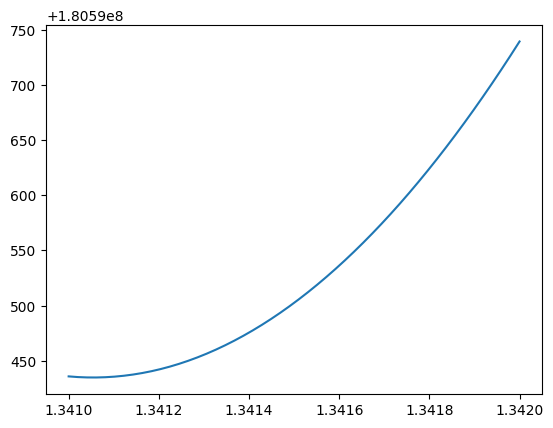

In [26]:
thetas_to_try = np.linspace(1.341,1.342)
mses = [mse(grav_agg(7.91523059e-01, 1.17685482e-02, 1.27603521e+00,thet,agg_mapping), va_commuter, county_name_index) for thet in thetas_to_try]

plt.plot(thetas_to_try, mses)

In [27]:
def grav_jacobian(tau1,tau2,rho,theta, pop,dist_mat, agg_mapping,inv_agg_mapping, commuter_flows, scale=False):
    matrix,influx = gravity_numba(
        np.array(vacc_df['pop']),
        np.array(dist_mat),
        np.array(vacc_df['pop']),
        tau1,tau2,rho,theta
    )
    agg_size = np.max(agg_mapping)+1
    agg_flows = np.zeros((agg_size,agg_size))
    matrix_size = np.shape(matrix)[0]
    for i in range(matrix_size):
        for j in range(matrix_size):
            agg_flows[ agg_mapping[i], agg_mapping[j] ] += matrix[i,j]
    
    residuals = []
    partial_theta = []
    partial_tau1 = []
    partial_tau2 = []
    partial_rho = []
    pred = []
    data = []
    n = len(commuter_flows.index)
    for index,row in commuter_flows.iterrows():
        try:
            from_index = county_name_index[row['from']]
            to_index = county_name_index[row['to']]
        except KeyError:
            continue
        residuals.append(agg_flows[from_index,to_index] - row['flow'])
        pred.append(agg_flows[from_index,to_index])
        data.append(row['flow'])
        partial_theta.append((1/theta)*agg_flows[from_index,to_index])

        grav_unsummed = []
        tau1_pop_logs = []
        tau2_pop_logs = []
        rho_factor = []
        for zip_index_from in inv_agg_mapping[county_name_index[row['from']]]:
            for zip_index_to in inv_agg_mapping[county_name_index[row['to']]]:
                if zip_index_from == zip_index_to:
                    continue
                grav_unsummed.append(
                    theta*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
                )
                tau1_pop_logs.append(
                    np.log(pop[zip_index_from])
                )
                tau2_pop_logs.append(
                    np.log(pop[zip_index_to])
                )
                rho_factor.append(
                    -np.log(dist_mat[zip_index_from, zip_index_to])/dist_mat[zip_index_from, zip_index_to]**rho
                )
        partial_tau1.append(np.array(grav_unsummed) @ np.array(tau1_pop_logs))
        partial_tau2.append(np.array(grav_unsummed) @ np.array(tau2_pop_logs))
        partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
    
    jac= np.array([
        (1/n)* np.array(residuals) @ np.array(partial_tau1),
        (1/n)* np.array(residuals) @ np.array(partial_tau2),
        (1/n)* np.array(residuals) @ np.array(partial_rho),
        (1/n)* np.array(residuals) @ np.array(partial_theta)
    ])
    if scale:
        jac = jac/np.linalg.norm(jac,ord=2)
    return jac

In [51]:
def grav_jacobian(tau1,tau2,rho,log_theta, pop,dist_mat, agg_mapping,inv_agg_mapping, commuter_flows, scale=False, return_data = False):
    matrix,influx = gravity_numba(
        np.array(vacc_df['pop']),
        np.array(dist_mat),
        np.array(vacc_df['pop']),
        tau1,tau2,rho,np.exp(log_theta)
    )
    agg_size = np.max(agg_mapping)+1
    agg_flows = np.zeros((agg_size,agg_size))
    matrix_size = np.shape(matrix)[0]
    for i in range(matrix_size):
        for j in range(matrix_size):
            agg_flows[ agg_mapping[i], agg_mapping[j] ] += matrix[i,j]
    
    residuals = []
    partial_theta = []
    partial_tau1 = []
    partial_tau2 = []
    partial_rho = []
    pred = []
    data = []
    n = len(commuter_flows.index)
    for index,row in commuter_flows.iterrows():
        try:
            from_index = county_name_index[row['from']]
            to_index = county_name_index[row['to']]
        except KeyError:
            continue
        residuals.append(agg_flows[from_index,to_index] - row['flow'])
        pred.append(agg_flows[from_index,to_index])
        data.append(row['flow'])
        partial_theta.append(np.exp(log_theta)*agg_flows[from_index,to_index])

        grav_unsummed = []
        tau1_pop_logs = []
        tau2_pop_logs = []
        rho_factor = []
        for zip_index_from in inv_agg_mapping[county_name_index[row['from']]]:
            for zip_index_to in inv_agg_mapping[county_name_index[row['to']]]:
                if zip_index_from == zip_index_to:
                    continue
                grav_unsummed.append(
                    np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
                )
                tau1_pop_logs.append(
                    np.log(pop[zip_index_from])
                )
                tau2_pop_logs.append(
                    np.log(pop[zip_index_to])
                )
                rho_factor.append(
                    -np.log(dist_mat[zip_index_from, zip_index_to])/dist_mat[zip_index_from, zip_index_to]**rho
                )
        partial_tau1.append(np.array(grav_unsummed) @ np.array(tau1_pop_logs))
        partial_tau2.append(np.array(grav_unsummed) @ np.array(tau2_pop_logs))
        partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
    
    jac= np.array([
        (1/n)* np.array(residuals) @ np.array(partial_tau1),
        (1/n)* np.array(residuals) @ np.array(partial_tau2),
        (1/n)* np.array(residuals) @ np.array(partial_rho),
        (1/n)* np.array(residuals) @ np.array(partial_theta)
    ])
    if scale:
        jac = jac/np.linalg.norm(jac,ord=2)
    if return_data:
        return jac, data, pred
    return jac

In [130]:
jac,data,preds = grav_jacobian(   1.3704949 ,   1.36992368,   0.99993131, -20.,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter, return_data=True)
#jac,data,preds = grav_jacobian(    1.48476602,   1.48419582,   0.99969819, -25.,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter, return_data=True)
#jac, data, preds = grav_jacobian(2.2, 0.8, 1.6, 3.7300000000e-11,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

(array([1.000e+00, 3.000e+00, 4.000e+00, 7.600e+01, 3.355e+03, 4.100e+01,
        9.000e+00, 6.000e+00, 0.000e+00, 2.000e+00]),
 array([-47685.46244364, -36420.5258925 , -25155.58934136, -13890.65279022,
         -2625.71623909,   8639.22031205,  19904.15686319,  31169.09341432,
         42434.02996546,  53698.9665166 ,  64963.90306773]),
 <BarContainer object of 10 artists>)

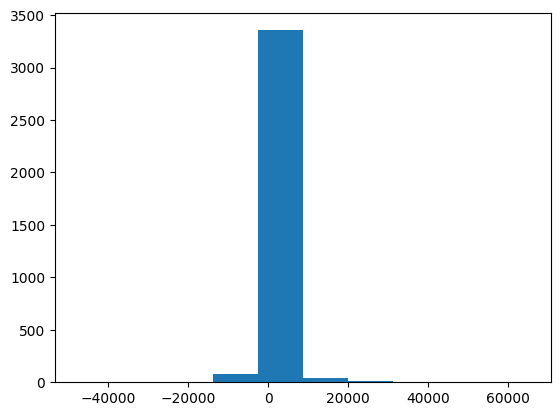

In [131]:
plt.hist(np.array(data)-np.array(preds))

In [138]:
mse(grav_agg(1.3704949 ,   1.36992368,   0.99993131, np.exp(-20),agg_mapping), va_commuter, county_name_index)

156325426.36792773

In [38]:
np.sum(np.abs(np.array(preds)-np.array(data)))

2926251.358657196

In [140]:
np.corrcoef(preds,data)**2

array([[1.        , 0.80050788],
       [0.80050788, 1.        ]])

In [40]:
np.exp(-15)

3.059023205018258e-07

In [47]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(data,preds,alpha=0.5)
axes = plt.gca()
#axes.set_xlim([0,1])
#axes.set_ylim([0,1000])
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')
abline(1,0)



NameError: name 'data' is not defined

<Figure size 640x480 with 0 Axes>

In [47]:
va_commuter[va_commuter['flow']< 1000]

,from,to,flow,error
1,accomack_county,chesterfield_county,9.0,17.0
2,accomack_county,fairfax_county,29.0,32.0
3,accomack_county,nelson_county,23.0,34.0
5,accomack_county,shenandoah_county,7.0,12.0
6,accomack_county,charlottesville_city,9.0,17.0
...,...,...,...,...
3525,winchester_city,chesapeake_city,24.0,32.0
3526,winchester_city,fairfax_city,11.0,16.0
3527,winchester_city,hampton_city,17.0,30.0
3528,winchester_city,harrisonburg_city,11.0,17.0


In [36]:
gradient

NameError: name 'gradient' is not defined

In [ ]:
gradient, residuals = grav_jacobian(2.2, .796, 1.56, 3.73e-10,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [ ]:
import seaborn as sns
sns.kdeplot(residuals)

In [50]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter[va_commuter['flow']< 1000], county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -25]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_21896/2070504612.py:43: RuntimeWarning: overflow encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_21896/2070504612.py:56: RuntimeWarning: invalid value encountered in matmul
  partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
/tmp/ipykernel_21896/2070504612.py:61: RuntimeWarning: invalid value encountered in matmul
  (1/n)* np.array(residuals) @ np.array(partial_rho),


      fun: 437509.7443219364
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.34594000e+07, -3.34056132e+07,  7.75034160e+05, -4.46968931e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 16
      nit: 2
     njev: 16
   status: 0
  success: True
        x: array([  1.48476602,   1.48419582,   0.99969819, -25.        ])

In [42]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -25]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_34351/2070504612.py:43: RuntimeWarning: overflow encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_34351/2070504612.py:56: RuntimeWarning: invalid value encountered in matmul
  partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
/tmp/ipykernel_34351/2070504612.py:61: RuntimeWarning: invalid value encountered in matmul
  (1/n)* np.array(residuals) @ np.array(partial_rho),


      fun: 159685794.59226522
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-2.26175073e+05,  5.44180541e+05,  3.75548006e+05, -7.57788891e-07])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 37
      nit: 6
     njev: 37
   status: 0
  success: True
        x: array([  1.61092363,   1.61000345,   0.99952051, -25.        ])

In [43]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -20]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_34351/2070504612.py:43: RuntimeWarning: overflow encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_34351/2070504612.py:56: RuntimeWarning: invalid value encountered in matmul
  partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
/tmp/ipykernel_34351/2070504612.py:61: RuntimeWarning: invalid value encountered in matmul
  (1/n)* np.array(residuals) @ np.array(partial_rho),


      fun: 156325426.57628542
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.19319206e+05,  3.87779712e+05,  3.50205453e+05,  3.64742112e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 38
      nit: 5
     njev: 38
   status: 0
  success: True
        x: array([  1.3704949 ,   1.36992368,   0.99993131, -20.        ])

In [ ]:
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -20]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
    ,options={'ftol':1e-10}
)

In [45]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_34351/2070504612.py:43: RuntimeWarning: overflow encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_34351/2070504612.py:56: RuntimeWarning: invalid value encountered in matmul
  partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
/tmp/ipykernel_34351/2070504612.py:61: RuntimeWarning: invalid value encountered in matmul
  (1/n)* np.array(residuals) @ np.array(partial_rho),


      fun: 161924980.58370838
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.33567307e+05,  2.90498530e+05,  3.10528380e+05,  1.88876199e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 5
     njev: 54
   status: 0
  success: True
        x: array([  1.12802691,   1.12753162,   0.99983554, -15.        ])

In [46]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -10]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_34351/2070504612.py:43: RuntimeWarning: overflow encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_34351/2070504612.py:52: RuntimeWarning: overflow encountered in double_scalars
  -np.log(dist_mat[zip_index_from, zip_index_to])/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_34351/2070504612.py:43: RuntimeWarning: invalid value encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_34351/2070504612.py:52: RuntimeWarning: divide by zero encountered in double_scalars
  -np.log(dist_mat[zip_index_from, zip_index_to])/dist_mat[zip_index_from, zip_index_to]**rho


      fun: 358458222.8261204
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 3.71931941e+08,  3.72251478e+08, -3.05080876e+06,  1.66406177e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 17
      nit: 2
     njev: 17
   status: 0
  success: True
        x: array([  1.        ,   1.        ,   1.99999998, -10.00019556])

In [47]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -5]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

      fun: 29074442438383.812
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.24522911e+13,  2.24523385e+13, -1.57553516e+11,  1.44022525e+10])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 2
     njev: 14
   status: 0
  success: True
        x: array([ 1.        ,  1.        ,  1.99958144, -5.02892993])

In [56]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array( [1.3704949 ,   1.36992368,   0.99993131, -15.]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ],
    options= {'ftol':1e-10}
)

      fun: 231714567775.17957
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.89484984e+11,  1.89488049e+11, -1.27442279e+09,  5.61284785e+03])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 14
      nit: 2
     njev: 14
   status: 0
  success: True
        x: array([  1.3704949 ,   1.36992368,   1.99993131, -15.00000132])

In [ ]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([7.91523059e-01, 1.17685482e-02, 1.27603521e+00, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

In [38]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_34351/2070504612.py:43: RuntimeWarning: overflow encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_34351/2070504612.py:56: RuntimeWarning: invalid value encountered in matmul
  partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
/tmp/ipykernel_34351/2070504612.py:61: RuntimeWarning: invalid value encountered in matmul
  (1/n)* np.array(residuals) @ np.array(partial_rho),


      fun: 161924980.58370838
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.33567307e+05,  2.90498530e+05,  3.10528380e+05,  1.88876199e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 5
     njev: 54
   status: 0
  success: True
        x: array([  1.12802691,   1.12753162,   0.99983554, -15.        ])

In [175]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([7.91523059e-01, 1.17685482e-02, 1.27603521e+00, -23]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

      fun: 794006447.4778887
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-7.33961099e-02, -7.12364092e-02,  1.08784196e-03, -7.39412288e-13])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 2
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([  0.8274988 ,   0.04665027,   1.27550295, -23.        ])

In [177]:
from scipy.optimize import minimize
minimize(
    fun = lambda x: mse(grav_agg(x[0],x[1],x[2],np.exp(x[3]),agg_mapping), va_commuter, county_name_index),
    jac = lambda x: np.array(grav_jacobian(x[0],x[1],x[2],x[3],np.array(vacc_df['pop']), 
                                            np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)),
    x0 = np.array([1, 1, 1, -15]),
    method = "L-BFGS-B",
    bounds = [
        (0,None),
        (0,None),
        (0,None),
        (None,None)
    ]
)

/tmp/ipykernel_17350/2070504612.py:43: RuntimeWarning: overflow encountered in double_scalars
  np.exp(log_theta)*(pop[zip_index_from]**tau1 * pop[zip_index_to]**tau2)/dist_mat[zip_index_from, zip_index_to]**rho
/tmp/ipykernel_17350/2070504612.py:56: RuntimeWarning: invalid value encountered in matmul
  partial_rho.append(np.array(grav_unsummed) @ np.array(rho_factor))
/tmp/ipykernel_17350/2070504612.py:61: RuntimeWarning: invalid value encountered in matmul
  (1/n)* np.array(residuals) @ np.array(partial_rho),


      fun: 161924980.58370838
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.33567307e+05,  2.90498530e+05,  3.10528380e+05,  1.88876199e-02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 54
      nit: 5
     njev: 54
   status: 0
  success: True
        x: array([  1.12802691,   1.12753162,   0.99983554, -15.        ])

In [74]:
gradient, residuals = grav_jacobian(1.33072759e-01, 7.30060613e-01, 1.89965473e+00, 3.73000000e-10,np.array(vacc_df['pop']), np.array(dist_mat),agg_mapping,inv_agg_mapping,va_commuter)

In [75]:
gradient

[-9.941221880993435e+19,
 -137.55723604657703,
 -140.2878286439419,
 1.0778291701475242]

try poisson regression at the county level for gravity.

In [26]:
pop_agg = np.zeros(133)
for index, pop in enumerate(vacc_df['pop']):
    pop_agg[agg_mapping[index]] += pop
print(pop_agg)

[ 32402.  78281. 128601.   7936.  21830.  27460.  11593. 211497.  40695.
   4581.  52542.  17043.   4125.  53403.  26161.  11567.  18262.   6765.
   6191.  26666.  25998.  15287.   3824.  11502.  55727. 220796. 308987.
  12292.  21527.  12025.   3292.  44192.   5631.  55825.   9761.  14272.
  11161.   8855. 973456.  79400.  14748.  55553.   7687.  19317.  41412.
  11865.  74306.  22584.  16069.  16614.  21430.  46411.   9471.  13308.
  28487. 122619. 133233.  36946. 239776.  39397.   1710.  28286.  32829.
  84946.  10007.  21127.   8552.   7372.  15486.  12170. 351813.  26725.
   8367.  88741.  10361.  85204.  58244.  28017.   8180.  25175.   7542.
  63116.  16728.  20060. 160852. 204584.  10357.  10382.   3933.  12176.
  40070.  21671.  14753.  50253.  45258.  11122.  84394.  25175.  18914.
  18990. 314921.  30421.  20416.  12058.   4777. 169797.  58538.  95775.
  11129.  76553.  23042.  34222.  18733.  40193.  31963.  10293. 117480.
 130621.  31581.  81784.   7643.  10773.  35802. 42

In [27]:
va_commuter_filtered = va_commuter
va_commuter_filtered = va_commuter_filtered[va_commuter_filtered['from'] != "greensville_county"]
va_commuter_filtered = va_commuter_filtered[va_commuter_filtered['to'] != "greensville_county"]
va_commuter_filtered = va_commuter_filtered[va_commuter_filtered['to'] != va_commuter_filtered['from']]

In [28]:
va_commuter_filtered['from']

1       accomack_county
2       accomack_county
3       accomack_county
4       accomack_county
5       accomack_county
             ...       
3525    winchester_city
3526    winchester_city
3527    winchester_city
3528    winchester_city
3529    winchester_city
Name: from, Length: 3365, dtype: object

In [29]:
from_N = [pop_agg[county_name_index[county]] for county in va_commuter_filtered['from']]
to_N = [pop_agg[county_name_index[county]] for county in va_commuter_filtered['from']]
dist = [
    dist_mat.iloc[county_name_index[county_from], county_name_index[county_to]] 
    for county_from,county_to 
    in zip(va_commuter_filtered['from'],
           va_commuter_filtered['to'])
]

In [51]:
log_from_N = np.log(np.array(from_N))
log_to_N = np.log(np.array(to_N))
neg_log_dist = -np.log(np.array(dist))

X = np.concatenate([[log_from_N], [log_to_N], [neg_log_dist], [np.ones(len(log_from_N))]],axis=0).T

non_log_X =  np.concatenate([[np.array(from_N)], [np.array(to_N)], [np.array(dist)], [np.ones(len(log_from_N))]],axis=0).T

In [31]:
X

array([[10.38597543, 10.38597543, -3.52525512,  1.        ],
       [10.38597543, 10.38597543, -3.22267627,  1.        ],
       [10.38597543, 10.38597543, -0.90531039,  1.        ],
       ...,
       [10.05492026, 10.05492026, -4.3989191 ,  1.        ],
       [10.05492026, 10.05492026, -4.4928469 ,  1.        ],
       [10.05492026, 10.05492026, -4.42641445,  1.        ]])

In [32]:
from sklearn.linear_model import PoissonRegressor
model = PoissonRegressor()
model.fit(X,np.array(va_commuter_filtered['flow']))

PoissonRegressor()

NameError: name 'abline' is not defined

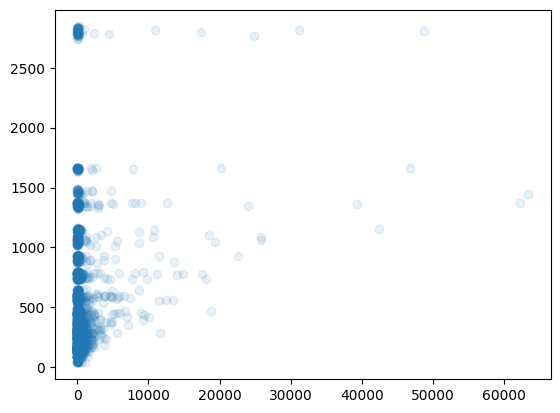

In [33]:
axes=plt.gca()
#axes.set_xlim([0,30000])
#axes.set_ylim([0,30000])
plt.scatter(np.array(va_commuter_filtered['flow']),model.predict(X),alpha=0.1)
abline(1,0)


In [52]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor()

model.fit(X,np.array(va_commuter_filtered['flow']))

RandomForestRegressor()

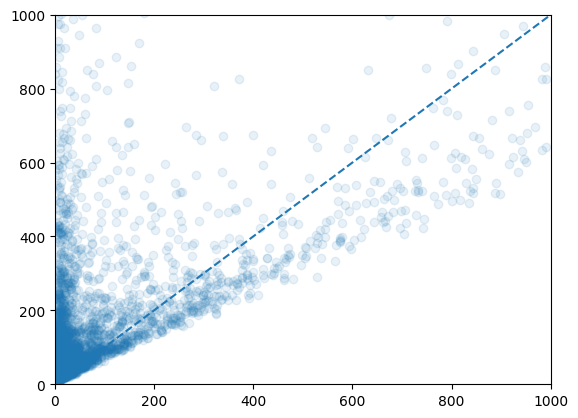

In [56]:

axes=plt.gca()
axes.set_xlim([0,1000])
axes.set_ylim([0,1000])
plt.scatter(np.array(va_commuter_filtered['flow']),model.predict(X),alpha=0.1)
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

abline(1,0)